# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://jupyterhub.ischool.syr.edu/ workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [39]:
# load these packages
import pyspark
from pyspark.ml import feature, classification
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

# Part 1: Random Forest and gradient boosted trees

In these questions, we will examine the famous [Auto dataset](https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Auto.html). With this dataset, the goal is to predict the miles per gallon (`mpg`) performance based on characteristics of the car such as number of cylinders (`cylinders`), displacement between wheels (`displacement`), horsepower of the engine (`horsepower`), weight of the car (`weight`), top acceleration (`acceleration`), year of the model (`year`), and origin (`origin`).

In [40]:
# read-only
mpg_df = spark.read.csv('Auto.csv', header=True, inferSchema=True).\
    drop('_c0').\
    withColumn('horsepower2', fn.col('horsepower').cast('int')).\
    drop('horsepower').\
    withColumnRenamed('horsepower2', 'horsepower').\
    dropna()
training_df, validation_df, testing_df = mpg_df.randomSplit([0.6, 0.3, 0.1], seed=0)
mpg_df.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- displacement: double (nullable = true)
 |-- weight: integer (nullable = true)
 |-- acceleration: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- origin: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- horsepower: integer (nullable = true)



# Question 1: (15 pts)

Create three pipelines that contain three different random forests and take in all features from `mpg_df` (`cylinders`, `displacement`, `horsepower`, `weight`, `acceleration`, `year`, and `origin`) to predict (`mpg`). **Set the `seed` parameter of the random forest to 0.** Fit these pipelines to the training data (`training_df`):

- `pipe_rf1`: Random forest with `maxDepth=2` and `numTrees=60`
- `pipe_rf2`: Random forest with `maxDepth=3` and `numTrees=40`
- `pipe_rf3`: Random forest with `maxDepth=6`, `numTrees=20`

In [41]:
# create the fitted pipelines `pipe_rf1`, `pipe_rf2`, and `pipe_rf3` here
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel

va = feature.VectorAssembler(inputCols=['cylinders', 'displacement', 'horsepower','weight', 'acceleration', 'year', 'origin'], outputCol='features')

rf =  RandomForestRegressor(labelCol='mpg',maxDepth=2, numTrees=60, seed=0)
pipe_rf1 = Pipeline(stages=[va, rf]).fit(training_df)

rf2 = RandomForestRegressor(labelCol='mpg',maxDepth=3, numTrees=40, seed=0)
pipe_rf2 = Pipeline(stages=[va, rf2]).fit(training_df)

rf3 = RandomForestRegressor(labelCol='mpg',maxDepth=6, numTrees=20, seed=0)
pipe_rf3 = Pipeline(stages=[va, rf3]).fit(training_df)

In [42]:
# tests for 10 pts
np.testing.assert_equal(type(pipe_rf1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_rf2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_rf3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_rf1.stages[1]), regression.RandomForestRegressionModel)
np.testing.assert_equal(type(pipe_rf2.stages[1]), regression.RandomForestRegressionModel)
np.testing.assert_equal(type(pipe_rf3.stages[1]), regression.RandomForestRegressionModel)
np.testing.assert_equal(type(pipe_rf1.transform(training_df)), pyspark.sql.dataframe.DataFrame)
np.testing.assert_equal(type(pipe_rf2.transform(training_df)), pyspark.sql.dataframe.DataFrame)
np.testing.assert_equal(type(pipe_rf3.transform(training_df)), pyspark.sql.dataframe.DataFrame)

# Question 2 (10 pts)

Use the following evaluator to compute the $R^2$ of the models on validation data. Assign the $R^2$ of the three models to `R2_1`, `R2_2`, and `R2_3`, respectively, and the performance. Assign the best pipeline based on validation performance to a variable `best_model`

In [43]:
evaluator = evaluation.RegressionEvaluator(labelCol='mpg', metricName='r2')
# use it as follows:
#   evaluator.evaluate(fitted_pipeline.transform(df)) -> R2

In [44]:
# YOUR CODE HERE

R2_1 = evaluator.evaluate(pipe_rf1.transform(validation_df))
R2_2 = evaluator.evaluate(pipe_rf2.transform(validation_df))
R2_3 = evaluator.evaluate(pipe_rf3.transform(validation_df))
best_model = pipe_rf3

In [45]:
# tests for 10 pts
np.testing.assert_equal(type(best_model.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(best_model.stages[1]), regression.RandomForestRegressionModel)
np.testing.assert_equal(type(best_model.transform(validation_df)), pyspark.sql.dataframe.DataFrame)
np.testing.assert_array_less(R2_1, 1.)
np.testing.assert_array_less(0.5, R2_1)
np.testing.assert_array_less(R2_2, 1.)
np.testing.assert_array_less(0.5, R2_2)
np.testing.assert_array_less(R2_3, 1.)
np.testing.assert_array_less(0.5, R2_3)

# Question 3: 5 pts

Compute the $R^2$ of the model on testing data, print it, and assign it to variable `R2_best`

In [46]:
# YOUR CODE HERE

R2_1 = evaluator.evaluate(pipe_rf1.transform(testing_df))
R2_2 = evaluator.evaluate(pipe_rf2.transform(testing_df))
R2_3 = evaluator.evaluate(pipe_rf3.transform(testing_df))
R2_best = R2_3

In [47]:
# tests for 5 pts
np.testing.assert_array_less(R2_best, 1.)
np.testing.assert_array_less(0.6, R2_best)

# Question 4: 5 pts

Using the parameters of the best model, create a new pipeline called `final_model` and fit it to the entire data (`mpg_df`)

In [48]:
# create the fitted pipeline `final_model` here
# YOUR CODE HERE
final_model = Pipeline(stages=[va, rf3]).fit(mpg_df)

In [49]:
# tests for 10 pts
np.testing.assert_equal(type(final_model.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(final_model.stages[1]), regression.RandomForestRegressionModel)
np.testing.assert_equal(type(final_model.transform(mpg_df)), pyspark.sql.dataframe.DataFrame)

# Question 5: 15 pts

Create a pandas dataframe `feature_importance` with the columns `feature` and `importance` which contains all the names of the features (`cylinder`, `displacement`, etc.) and their feature importances as determined by the random forest of the final model. Sort the dataframe by `importance` in descending order.

In [50]:
# create feature_importance below
# YOUR CODE HERE

feature = va.getInputCols()
importance= final_model.stages[-1].featureImportances.toArray()

feature_importance  = pd.DataFrame(list(zip(feature, importance)), 
             columns = ['feature', 'importance']).sort_values('importance', ascending=False)

In [51]:
# display it here
feature_importance 

,feature,importance
1,displacement,0.379758
2,horsepower,0.172883
3,weight,0.143796
0,cylinders,0.134298
5,year,0.133876
4,acceleration,0.024922
6,origin,0.010467


In [52]:
# tests for 5 pts
assert type(feature_importance) == pd.core.frame.DataFrame
np.testing.assert_array_equal(list(feature_importance.columns), ['feature', 'importance'])
np.testing.assert_array_equal(list(feature_importance.columns), ['feature', 'importance'])

**(10 pts)** Comment below on the importance that random forest has given to each feature. Are they reasonable? Do they tell you anything valuable about the mpg dataset? Answer in the cell below

Displacement and horsepower have a negative correlation with MPG, therefore a good starting point for partitioning 

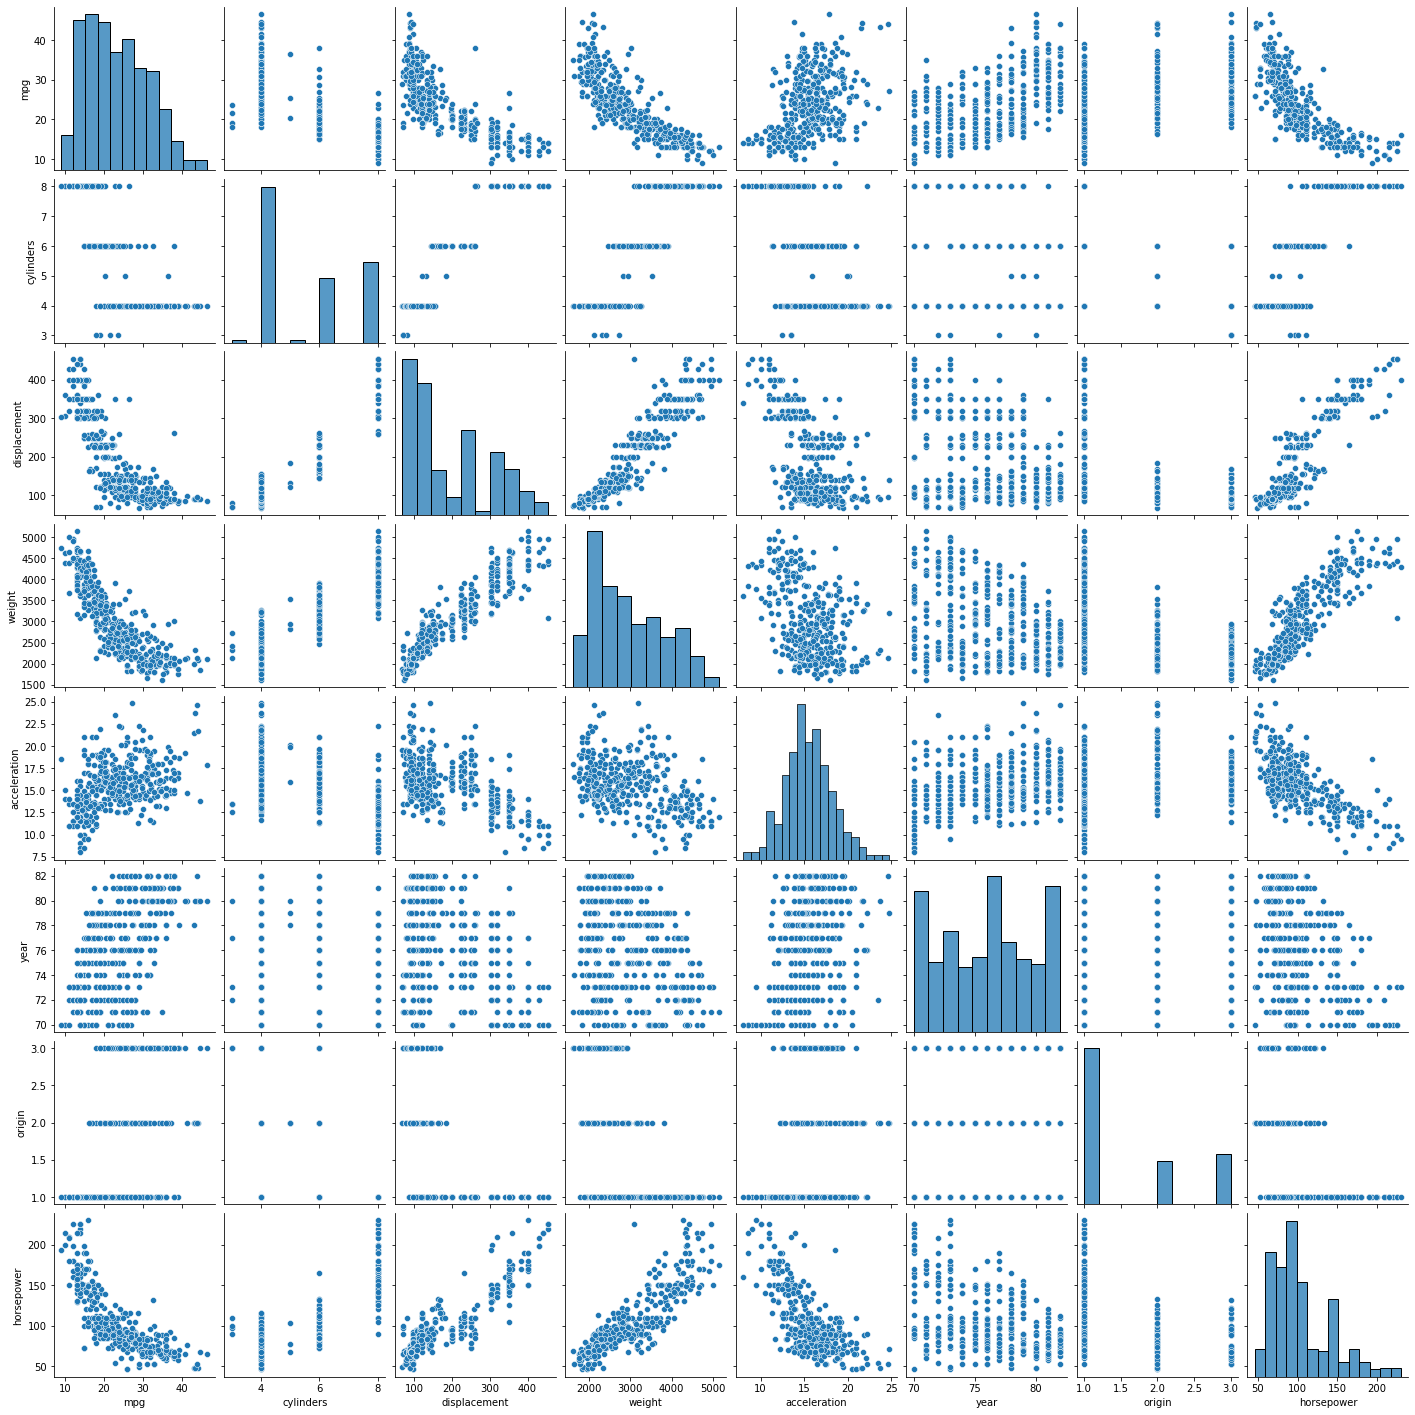

In [53]:
import seaborn as sns
df = mpg_df.toPandas()
sns.pairplot(df)

# Question 6:  10 pts.

Pick any of the trees from the final model and assign its `toDebugString` property to a variable `example_tree`. Print this variable and **add comments** to the cell describing how you think this particular tree is fitting the data.

In [70]:
# create a variable example_tree with the toDebugString property of a tree from final_model.
# print this string and comment in this same cell about the branches that this tree fit
# YOUR CODE HERE


example_tree = final_model.stages[-1].trees[0].toDebugString

print(example_tree)
# (5 pts) Comment:
## the tree splits on displacement, horsepower, and weight: lower values yield a higher mpg prediction. 

DecisionTreeRegressionModel: uid=dtr_4f2d29301914, depth=6, numNodes=97, numFeatures=7
  If (feature 1 <= 159.5)
   If (feature 2 <= 74.5)
    If (feature 1 <= 93.5)
     If (feature 3 <= 2139.5)
      If (feature 3 <= 2047.5)
       If (feature 3 <= 1834.5)
        Predict: 35.58181818181818
       Else (feature 3 > 1834.5)
        Predict: 33.80526315789474
      Else (feature 3 > 2047.5)
       If (feature 5 <= 79.5)
        Predict: 38.699999999999996
       Else (feature 5 > 79.5)
        Predict: 42.73333333333333
     Else (feature 3 > 2139.5)
      Predict: 25.0
    Else (feature 1 > 93.5)
     If (feature 3 <= 2271.5)
      If (feature 4 <= 18.25)
       If (feature 5 <= 78.5)
        Predict: 29.928571428571427
       Else (feature 5 > 78.5)
        Predict: 34.141176470588235
      Else (feature 4 > 18.25)
       If (feature 6 <= 1.5)
        Predict: 24.5
       Else (feature 6 > 1.5)
        Predict: 26.25
     Else (feature 3 > 2271.5)
      If (feature 2 <= 65.5)
       

In [71]:
# tests for 5 points
assert type(example_tree) == str
assert 'DecisionTreeRegressionModel' in example_tree
assert 'feature 0' in example_tree
assert 'If' in example_tree
assert 'Else' in example_tree
assert 'Predict' in example_tree

# **Question 7 (10 pts)**

Gradient boosted trees are becoming increasingly popular for competitions. There is a high-performance implementation, [xgboost](https://en.wikipedia.org/wiki/XGBoost), that is particularly popular. Compare gradient boosted regression to the best model found with random forest in Question 3 using the `validation set`. For GBR, use all the default parameters except make `seed=0`. Assign the pipeline and the $R^2$ of the model to `gbr_pipe` and `R2_gbr`, respectively. Does it have an amazing or dissapointing $R^2$? **Comment below**.

In [ ]:
# YOUR CODE HERE
from pyspark.ml.regression import GBTRegressor

va = feature.VectorAssembler(inputCols=['cylinders', 'displacement', 'horsepower','weight', 'acceleration', 'year', 'origin'], outputCol='features')

gbt = GBTRegressor(labelCol='mpg', featuresCol='features', seed=0)
gbr_pipe = Pipeline(stages=[va, gbt]).fit(training_df)

R2_gbr = evaluator.evaluate(gbr_pipe.transform(validation_df))



In [ ]:
# test your models here
print("Performance of best RF: ", evaluator.evaluate(best_model.transform(validation_df)))
print("Performance of GBR: ", R2_gbr)

In [ ]:
# (5 pts) Comment:
# Dissapointing R2

In [ ]:
# tests for 5 pts
np.testing.assert_equal(type(gbr_pipe.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(gbr_pipe.stages[1]), regression.GBTRegressionModel)
np.testing.assert_equal(type(gbr_pipe.transform(validation_df)), pyspark.sql.dataframe.DataFrame)
np.testing.assert_array_less(R2_gbr, 1.)
np.testing.assert_array_less(0.5, R2_gbr)